# TOC:
* [Imports](#imports)
* [Util Methods & Constants](#utils)
* [Load Data](#load-data)
    * [Load pre processed training data](#load-data)
        *   [Split data](#split-data)
    * [Load daily stock data](#load-daily-data)
* [Create testsplits](#create-test-splits)
* [Train regressors](#train-regressors)
* [Trade Simulations](#trade-simulations)
* [Analysis](#analysis)


# Imports <a class="anchor" id="imports"></a>

In [95]:
from sklearn.model_selection import train_test_split , ShuffleSplit
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
import random

import backtrader as bt

import matplotlib.pyplot as plt
from tabulate import tabulate

# Util methods & Constants <a class="anchor" id="utils"></a>

In [96]:
# Constants
predict_variables = ['1Month','3Months','6Months','1Year','2Years']
meta_variables =  ['date', 'symbol', 'source']
non_test_variables = predict_variables + meta_variables
train_variables = ["Day1Prior","Day2Prior","Day3Prior","Day4Prior","Day5Prior","Day6Prior","Week1Prior","Week2Prior","Week3Prior","Month1Prior","Month2Prior","Month3Prior","Month4Prior","Month5Prior","Month6Prior","Month7Prior","Month8Prior","Month9Prior","Month10Prior","Month11Prior","Month12Prior","Month13Prior","Month14Prior","Month15Prior","Month16Prior","Month17Prior","Month18Prior","Month19Prior","Month20Prior","Month21Prior","Month22Prior","Month23Prior","Month24Prior"]

short_value = -1
long_value = 0
test_size = 0.4

enable_debug_prints = False
run_random = False

In [97]:
# Util methods

# Method to find nearest date to a given pivot
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

# Classifies a varibale an imput as either short or long
def classify_long_short(x):
    if(x == 'short'):
        return short_value
    elif(x == 'long'):
        return long_value
    else:
        return 

def classify(x):
    if(x < (short_value+long_value)/2):
        return short_value
    else:
        return long_value

# Load data <a class="anchor" id="load-data"></a>
## Load pre processed training data <a class="anchor" id="load-data"></a>


In [98]:
classified_data = pd.read_csv('csv/table_all_class.csv',sep=',')
u_symbol = classified_data['SYMBOL'].unique()
date = pd.Series(classified_data['Date'])
classified_data.drop(['Date'],axis=1,inplace=True)
classified_data['date'] = date.apply(lambda x: np.datetime64(x))
classified_data.rename(columns={"SYMBOL": "symbol"}, inplace=True)
for variable in predict_variables:
    classified_data[variable] = classified_data[variable].apply(lambda x: classify_long_short(x))
classified_data[0:2]

,symbol,1Month,3Months,6Months,1Year,2Years,Day1Prior,Day2Prior,Day3Prior,Day4Prior,...,Month17Prior,Month18Prior,Month19Prior,Month20Prior,Month21Prior,Month22Prior,Month23Prior,Month24Prior,source,date
0,ALT,NaN,NaN,NaN,NaN,NaN,0.065012,-0.133654,-0.136973,-0.136973,...,-0.340892,-0.502210,-0.199111,-0.001109,0.794821,0.722753,0.371385,0.202937,Kerrisdale Capital,2024-02-14
1,JOBY,-1.0,-1.0,NaN,NaN,NaN,-0.067073,-0.055556,-0.054096,-0.054096,...,0.148218,0.176923,0.256674,0.277662,0.071804,-0.098675,-0.337662,-0.322259,Kerrisdale Capital,2023-10-11


### Split data into individual datasets  <a class="anchor" id="split-data"></a>
* Spliting data into individual datasets so that each prediction period can be trained with the maximum amount of data not including NaN
* We also drop rows with NaN values in the colums we train on

In [99]:
split_classification_data = {}
classification_data_before_and_after_drop = {}
before_drop = len(classified_data)
# we drop rows with NaN values for each predict variable. So if there is NaN for 2 Years but not for 6Months, 6Months can be trained on that data
for variable in predict_variables:
    entry = {}
    entry['before_drop'] = before_drop
    split_classification_data[variable] = classified_data.dropna(subset=[variable]+train_variables)
    entry['after_drop'] = len(split_classification_data[variable])
    classification_data_before_and_after_drop[variable] = entry

for index, row in classification_data_before_and_after_drop.items():
    print("Variable: {0}  \t before drop: {1}\t after drop: {2}".format(index,row['before_drop'],row['after_drop']))

Variable: 1Month  	 before drop: 448	 after drop: 306
Variable: 3Months  	 before drop: 448	 after drop: 302
Variable: 6Months  	 before drop: 448	 after drop: 288
Variable: 1Year  	 before drop: 448	 after drop: 266
Variable: 2Years  	 before drop: 448	 after drop: 225


## Load daily stock data <a class="anchor" id="load-daily-data"></a>

In [100]:
# Daily data
clean_data = pd.read_csv('csv/clean_data_new.csv',sep=',')
u_symbol = clean_data['symbol'].unique()
date = pd.Series(clean_data['datetime'])
clean_data.drop(['datetime'],axis=1,inplace=True)
clean_data['date'] = date.apply(lambda x: np.datetime64(x))

stock_data = {}
for symbol in u_symbol:
    stock_data[symbol] = clean_data[clean_data['symbol'] == symbol]

stock_data[list(stock_data.keys())[0]][0:2]

,open,high,low,close,volume,symbol,log_returns,date
0,32.30,33.58,32.3,32.84,7315000.0,1179.HK,0.056371,2020-09-23
1,34.08,34.20,33.5,33.73,2797160.0,1179.HK,0.026740,2020-09-24


# Create test splits<a class="anchor" id="create-test-splits"></a>
* We create a specific sorted test split for each training variable

In [101]:
classified_test_splits = {}
for variable in predict_variables:
    # We sort the array to prevent having future data in training set. 
    sorted_data = split_classification_data[variable].sort_values(['date'], ascending= True)
    train, test = train_test_split(sorted_data, test_size=test_size, shuffle = False)
    classified_test_splits[variable] = {'train': train, 'test': test}
    # Making sure we got no overlap
    if(train['date'].iloc[0] >= train['date'].iloc[-1]):
        raise Exception("First date of training data is higher than last date") 
    if(test['date'].iloc[0] >= test['date'].iloc[-1]):
        raise Exception("First date of test data is higher than last date") 
    if(train['date'].iloc[-1] >= test['date'].iloc[0]):
        raise Exception("Overlap of training and test data")
    if(enable_debug_prints):
        print("First date of \033[92mtraining\033[0m data: \t{0}".format(train['date'].iloc[0]))
        print("Last date of \033[92mtraining\033[0m data:  \t{0}".format(train['date'].iloc[-1]))
        print("First date of \x1b[31mtest\x1b[0m data:     \t{0}".format(test['date'].iloc[0]))
        print("Last date of \x1b[31mtest\x1b[0m data:      \t{0}".format(test['date'].iloc[-1]))
classified_test_splits[list(classified_test_splits.keys())[0]]['train'][0:1]

,symbol,1Month,3Months,6Months,1Year,2Years,Day1Prior,Day2Prior,Day3Prior,Day4Prior,...,Month17Prior,Month18Prior,Month19Prior,Month20Prior,Month21Prior,Month22Prior,Month23Prior,Month24Prior,source,date
145,BDBD,-1.0,-1.0,0.0,0.0,-1.0,-0.028139,0.033372,-0.016429,-0.016429,...,0.358548,0.866944,0.733591,0.691149,0.781746,0.799599,1.017978,1.158654,Spruce Point Capital,2013-03-06


# Train regressors  <a class="anchor" id="train-regressors"></a>

In [102]:
# A list of subsets containing the indexes of the training variables we want to train on
train_subsets = []
train_subsets.append(np.arange(0,33))
regressors = {}
subset_index = 0
for subset in train_subsets:
    subset_regressors = {}
    cm_regressors = {}
    for variable in predict_variables:
        df = classified_test_splits[variable]
        train = df['train']
        test = df['test']
        # select the subset of trainingvariables 
        train_subset = [train_variables[i] for i in subset]
        x_train = np.array(train.drop(non_test_variables,axis=1)[train_subset])
        y_train = np.array(train[variable])
        x_test = np.array(test.drop(non_test_variables,axis=1)[train_subset])
        y_test = np.array(test[variable])

        # Define classifier
        regressor = xgb.XGBRegressor()
        # Train on trainsplit
        regressor.fit(x_train,y_train)
        # Create confusion matrix
        labels = [long_value,short_value]
        y_pred = np.array(list(map(classify, regressor.predict(x_test))))
        cm = confusion_matrix(y_pred, y_test,labels=labels)
        subset_regressors[variable] = {'regressor': regressor, 'confusion_matrix' : cm}
    regressors[subset_index] = subset_regressors
    subset_index += 1

# Trade simulations <a class="anchor" id="trade-simulations"></a>
* Trade functions take a dataset and a regressor then simulates a simple trading strategy

In [103]:
# A strategy that will go long if regressor predicts long and short if it predicts short
# If rnd is enabled will trade randomly
def trade_long_and_short(test, regressor, rnd=False):
    returns = {}
    for index, row in test.iterrows():
        prediction = 0
        if(rnd):
            prediction = random.randint(-1,1)
        else:
            x = np.array(test[test['SYMBOL'] == row['SYMBOL']].drop(non_test_variables, axis=1))
            prediction = regressor.predict(x)[0]
        # print(f"prediction 2 Years for stock{row['SYMBOL']} : {prediction_2y}")

        df = stock_data[row['SYMBOL']]

        # Get the first date after short selling report
        entry_date = row['date']
        entry_pivot = nearest(np.array(df['date']),entry_date)
        entry_data = df[df['date'] == entry_pivot]
        entry_price = (entry_data['high'].values[0] + entry_data['low'].values[0])/2

        exit_date = row['date'] + np.timedelta64(365,'D')
        # Get the first date 2 years after entring the market
        exit_pivot = nearest(np.array(df['date']), exit_date)
        exit_data = df[df['date'] == exit_pivot]
        exit_price = (exit_data['high'].values[0] + exit_data['low'].values[0])/2

        profit = 0
        profit_percentage = 0
        result = {}
        if(prediction == long_value):
            # long
            profit = exit_price - entry_price
            profit_percentage = profit/ entry_price * 100
        else:
            # short
            profit = entry_price - exit_price
            profit_percentage = profit/ entry_price * 100
            

        result['entry_price'] = entry_price
        result['exit_price'] = exit_price
        result['strategy'] = 'long' if prediction > 0 else 'short'
        result['profit'] = profit
        result['profit_percentage'] = profit_percentage
        returns[row['SYMBOL']] = result
    return(returns)

# Analysis <a class="anchor" id="analysis"></a>

Confusion matrix for index: 0 and period: 1Month
Confusion matrix for index: 0 and period: 3Months
Confusion matrix for index: 0 and period: 6Months
Confusion matrix for index: 0 and period: 1Year
Confusion matrix for index: 0 and period: 2Years


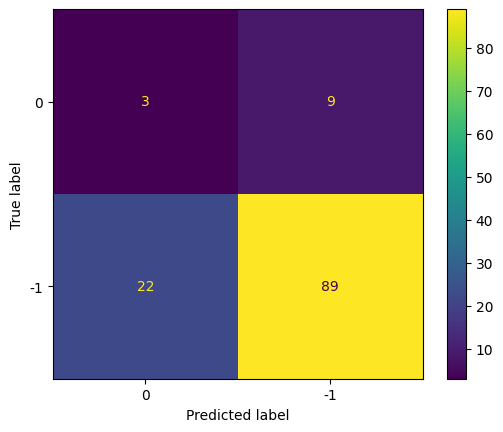

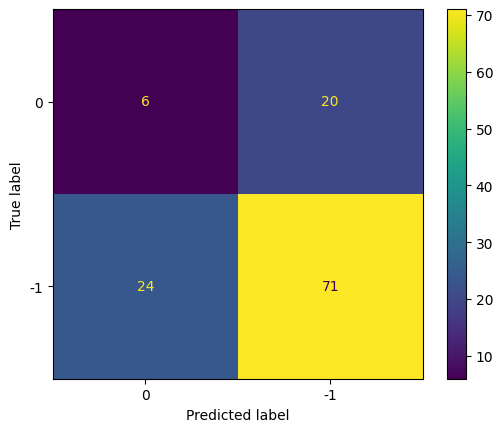

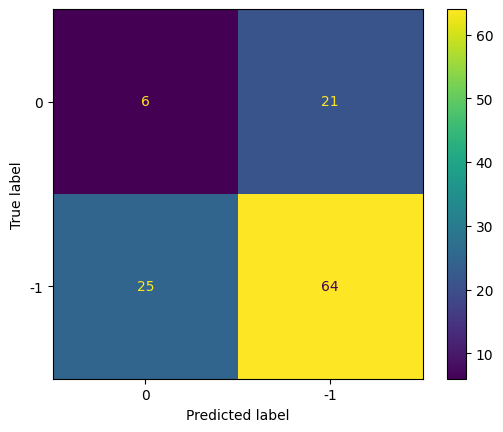

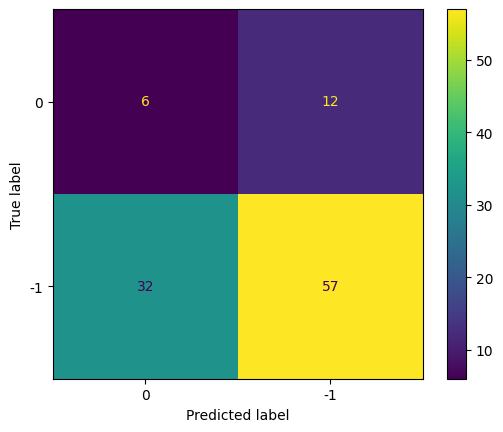

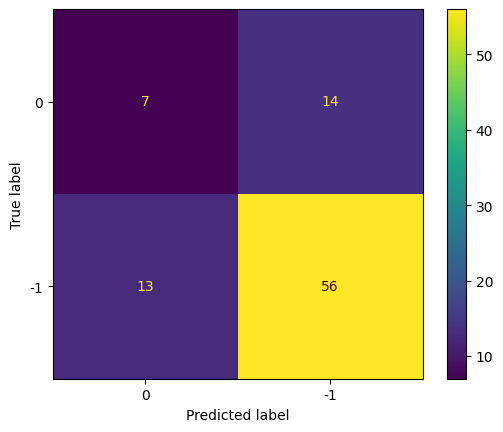

In [104]:
# Checking Confusion matrixes
for index in regressors:

    for key in regressors[index].keys():
        cm = regressors[index][key]['confusion_matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
        print('Confusion matrix for index: \033[92m{0}\033[0m and period: \033[92m{1}\033[0m'.format(index,key))
        disp.plot()